# Imports and Setup

In [1]:
import os
import sys
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Add src directory to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Device: cuda
   GPU: NVIDIA B200
   Memory: 191.51 GB


In [2]:
# Setup path to access custom modules
root_directory = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(root_directory, 'src'))

from ModelDataGenerator import build_dataloader

# Model - UNet Architecture

In [3]:
class UNetBlock(nn.Module):
    """Double convolution block with batch normalization"""
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

In [4]:
class UNet(nn.Module):
    """
    UNet Architecture for medical image super-resolution
    Input: (B, 2, H, W) - prior and posterior slices
    Output: (B, 1, H, W) - predicted middle slice
    """
    def __init__(self, in_channels=2, out_channels=1, init_features=64):
        super(UNet, self).__init__()
        
        features = init_features
        
        # Encoder
        self.enc1 = UNetBlock(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = UNetBlock(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3 = UNetBlock(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4 = UNetBlock(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = UNetBlock(features * 8, features * 16)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.dec4 = UNetBlock(features * 16, features * 8)
        
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.dec3 = UNetBlock(features * 8, features * 4)
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(features * 4, features * 2)
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(features * 2, features)
        
        # Final output layer
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder with skip connections
        enc1 = self.enc1(x)
        x = self.pool1(enc1)
        
        enc2 = self.enc2(x)
        x = self.pool2(enc2)
        
        enc3 = self.enc3(x)
        x = self.pool3(enc3)
        
        enc4 = self.enc4(x)
        x = self.pool4(enc4)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)
        
        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)
        
        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)
        
        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)
        
        # Output
        x = self.final_conv(x)
        return x

In [5]:
# Test model initialization
model = UNet(in_channels=2, out_channels=1, init_features=64)
print(f"Model created successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model created successfully!
Total parameters: 31,042,945


# Load Data from ModelDataGenerator

In [6]:
# Configuration
BATCH_SIZE = 4
NUM_WORKERS = 4  # Set to 0 for Windows, increase for Linux
AUGMENT = True

# Build dataloaders
train_loader = build_dataloader(
    split="train",
    batch_size=BATCH_SIZE,
    augment=AUGMENT,
    num_workers=NUM_WORKERS
)

val_loader = build_dataloader(
    split="val",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

test_loader = build_dataloader(
    split="test",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

# Display sample batch shapes
print("\nSample batch shapes:")
for (pre, post), target in train_loader:
    print(f"Prior: {pre.shape}")
    print(f"Posterior: {post.shape}")
    print(f"Target (middle): {target.shape}")
    break

Train loader: 18269 batches
Val loader: 3221 batches
Test loader: 4560 batches

Sample batch shapes:
Prior: torch.Size([4, 1, 256, 256])
Posterior: torch.Size([4, 1, 256, 256])
Target (middle): torch.Size([4, 1, 256, 256])


In [7]:
# CUDA Memory Optimization
def clear_gpu_memory():
    """Clear GPU cache and garbage collect"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    print("✅ GPU memory cleared")

# Check initial GPU memory
if torch.cuda.is_available():
    initial_memory = torch.cuda.memory_allocated() / 1e9
    reserved_memory = torch.cuda.memory_reserved() / 1e9
    print(f"Initial GPU Memory Usage:")
    print(f"   Allocated: {initial_memory:.2f} GB")
    print(f"   Reserved: {reserved_memory:.2f} GB")
    print(f"   Total Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Clear any pre-existing GPU memory
clear_gpu_memory()

Initial GPU Memory Usage:
   Allocated: 0.00 GB
   Reserved: 0.00 GB
   Total Available: 191.51 GB
✅ GPU memory cleared


In [8]:
# Training Configuration
EPOCHS = 20
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5
MODEL_SAVE_DIR = Path('../models')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("Training Configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Augmentation: {AUGMENT}")
print(f"Model save dir: {MODEL_SAVE_DIR}")
print()

# Initialize model, optimizer, and loss
model = UNet(in_channels=2, out_channels=1, init_features=64).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

Training Configuration:
Epochs: 20
Learning rate: 0.0001
Early stopping patience: 5
Batch size: 4
Augmentation: True
Model save dir: ../models



# Training Setup

In [9]:
# ========== Checkpoint Utilities ==========
def get_latest_checkpoint(checkpoint_dir, prefix='unet_checkpoint'):
    """Get the latest checkpoint file by epoch number"""
    from pathlib import Path
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_files = list(checkpoint_dir.glob(f'{prefix}_*.pt'))
    
    if not checkpoint_files:
        checkpoint_files = list(checkpoint_dir.glob('unet_combined_best.pt'))
        if checkpoint_files:
            return checkpoint_files[0], 10
        return None
    
    # Extract epoch numbers and sort
    checkpoints_with_epochs = []
    for ckpt in checkpoint_files:
        try:
            epoch = int(ckpt.stem.split('_')[-1])
            checkpoints_with_epochs.append((epoch, ckpt))
        except ValueError:
            continue
    
    if not checkpoints_with_epochs:
        return None
    
    # Return path of checkpoint with highest epoch
    latest_epoch, latest_ckpt = max(checkpoints_with_epochs, key=lambda x: x[0])
    return latest_ckpt, latest_epoch


def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Load checkpoint and return starting epoch and training state"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    start_epoch = checkpoint.get('epoch', 0) + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    
    # Extract loss components if they exist
    loss_components = checkpoint.get('loss_components', {})
    
    return start_epoch, train_losses, val_losses, best_val_loss, loss_components


def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, loss_components, best_val_loss, checkpoint_path):
    """Save checkpoint with all training state"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'loss_components': loss_components
    }
    torch.save(checkpoint, checkpoint_path)

print("✅ Checkpoint utilities defined")

✅ Checkpoint utilities defined


# ========== TRAINING SETUP 1: MSE LOSS ==========

In [11]:
# ========== Checkpoint Setup for MSE Training ==========
CHECKPOINT_DIR_MSE = MODEL_SAVE_DIR
CHECKPOINT_DIR_MSE.mkdir(parents=True, exist_ok=True)

print("🔍 Checking for existing MSE checkpoints...")
latest_mse_ckpt = get_latest_checkpoint(CHECKPOINT_DIR_MSE, prefix='unet_checkpoint')

if latest_mse_ckpt is not None:
    latest_ckpt_path, latest_epoch = latest_mse_ckpt
    print(f"📂 Found checkpoint: {latest_ckpt_path.name}")
    
    # Load checkpoint
    start_epoch_mse, train_losses_mse, val_losses_mse, best_val_loss_mse, _ = load_checkpoint(
        model, optimizer, latest_ckpt_path, DEVICE
    )
    
    print(f"✅ Loaded checkpoint from epoch {latest_epoch}")
    print(f"   Resuming training from epoch {start_epoch_mse}")
    print(f"   Best validation loss so far: {best_val_loss_mse:.4f}\n")
else:
    print("📭 No MSE checkpoint found - starting fresh training\n")
    start_epoch_mse = 1
    train_losses_mse = []
    val_losses_mse = []
    best_val_loss_mse = float('inf')

print("✅ MSE Training Setup Complete")

🔍 Checking for existing MSE checkpoints...
📂 Found checkpoint: unet_best.pt
✅ Loaded checkpoint from epoch 10
   Resuming training from epoch 16
   Best validation loss so far: 0.0735

✅ MSE Training Setup Complete


# MSE Loss Training Configuration and Setup

## Training Loop

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for (pre, post), target in pbar:
        # Stack prior and posterior as input (2 channels)
        inputs = torch.cat([pre, post], dim=1).to(device)
        targets = target.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for (pre, post), target in pbar:
            # Stack prior and posterior as input (2 channels)
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss

## Epoch 1-10

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for (pre, post), target in pbar:
        # Stack prior and posterior as input (2 channels)
        inputs = torch.cat([pre, post], dim=1).to(device)
        targets = target.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for (pre, post), target in pbar:
            # Stack prior and posterior as input (2 channels)
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss


# Initialize training variables from checkpoint if resuming
if start_epoch_mse > 1:
    print(f"📊 Resuming MSE Training from epoch {start_epoch_mse}")
    print(f"   Previous epochs: {len(train_losses_mse)}")
    print(f"   Best val loss: {best_val_loss_mse:.4f}\n")
else:
    print(f"🆕 Starting fresh MSE training\n")

patience_counter_mse = 0

print(f"Starting MSE Loss training...\n")
print("=" * 70)

for epoch in range(start_epoch_mse, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss = validate(model, val_loader, criterion, DEVICE)
    
    train_losses_mse.append(train_loss)
    val_losses_mse.append(val_loss)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_mse:
            best_val_loss_mse = val_loss
            patience_counter_mse = 0
            
            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_mse,
                'val_losses': val_losses_mse,
                'loss_components': {}
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_best.pt')
            print("(Best)")
        else:
            patience_counter_mse += 1
            print(f" (patience: {patience_counter_mse}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_mse >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        checkpoint_path = CHECKPOINT_DIR_MSE / f'unet_mse_checkpoint_{epoch}.pt'
        save_checkpoint(model, optimizer, epoch, train_losses_mse, val_losses_mse, {}, best_val_loss_mse, checkpoint_path)

print("=" * 70)
print(f"MSE Loss Training completed!")
print(f"Best validation loss: {best_val_loss_mse:.4f}")
print(f"Total epochs trained: {len(train_losses_mse)}")

Starting training...



Epoch   1/10 | Train Loss: 0.0798 | Val Loss: 0.0878(Best)


Epoch   2/10 | Train Loss: 0.0680 | Val Loss: 0.0833(Best)


Epoch   3/10 | Train Loss: 0.0649 | Val Loss: 0.0832(Best)


Epoch   4/10 | Train Loss: 0.0631 | Val Loss: 0.0848 (patience: 1/5)


Epoch   5/10 | Train Loss: 0.0619 | Val Loss: 0.0792(Best)


Epoch   6/10 | Train Loss: 0.0609 | Val Loss: 0.0795 (patience: 1/5)


Epoch   7/10 | Train Loss: 0.0601 | Val Loss: 0.0791(Best)


Epoch   8/10 | Train Loss: 0.0595 | Val Loss: 0.0822 (patience: 1/5)


Epoch   9/10 | Train Loss: 0.0590 | Val Loss: 0.0803 (patience: 2/5)


Epoch  10/10 | Train Loss: 0.0584 | Val Loss: 0.0767(Best)
Training completed!
Best validation loss: 0.0767


## Epoch 11-15

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for (pre, post), target in pbar:
        # Stack prior and posterior as input (2 channels)
        inputs = torch.cat([pre, post], dim=1).to(device)
        targets = target.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for (pre, post), target in pbar:
            # Stack prior and posterior as input (2 channels)
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss


# Initialize training variables from checkpoint if resuming
if start_epoch_mse > 1:
    print(f"📊 Resuming MSE Training from epoch {start_epoch_mse}")
    print(f"   Previous epochs: {len(train_losses_mse)}")
    print(f"   Best val loss: {best_val_loss_mse:.4f}\n")
else:
    print(f"🆕 Starting fresh MSE training\n")

patience_counter_mse = 0

print(f"Starting MSE Loss training...\n")
print("=" * 70)

for epoch in range(start_epoch_mse, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss = validate(model, val_loader, criterion, DEVICE)
    
    train_losses_mse.append(train_loss)
    val_losses_mse.append(val_loss)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_mse:
            best_val_loss_mse = val_loss
            patience_counter_mse = 0
            
            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_mse,
                'val_losses': val_losses_mse,
                'loss_components': {}
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_best.pt')
            print("(Best)")
        else:
            patience_counter_mse += 1
            print(f" (patience: {patience_counter_mse}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_mse >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        checkpoint_path = CHECKPOINT_DIR_MSE / f'unet_mse_checkpoint_{epoch}.pt'
        save_checkpoint(model, optimizer, epoch, train_losses_mse, val_losses_mse, {}, best_val_loss_mse, checkpoint_path)

print("=" * 70)
print(f"MSE Loss Training completed!")
print(f"Best validation loss: {best_val_loss_mse:.4f}")
print(f"Total epochs trained: {len(train_losses_mse)}")

📊 Resuming MSE Training from epoch 11
   Previous epochs: 10
   Best val loss: 0.0767

Starting MSE Loss training...



Epoch  11/20 | Train Loss: 0.0576 | Val Loss: 0.0743(Best)


Epoch  12/20 | Train Loss: 0.0571 | Val Loss: 0.0736(Best)


Epoch  13/20 | Train Loss: 0.0568 | Val Loss: 0.0739 (patience: 1/5)


Epoch  14/20 | Train Loss: 0.0565 | Val Loss: 0.0737 (patience: 2/5)


Epoch  15/20 | Train Loss: 0.0562 | Val Loss: 0.0735(Best)


Training:  49%|████▉     | 9023/18269 [52:31<54:44,  2.82it/s, loss=0.0230]  

## Epoch 16 and above

In [ ]:
# Initialize training variables from checkpoint if resuming
if start_epoch_mse > 1:
    print(f"📊 Resuming MSE Training from epoch {start_epoch_mse}")
    print(f"   Previous epochs: {len(train_losses_mse)}")
    print(f"   Best val loss: {best_val_loss_mse:.4f}\n")
else:
    print(f"🆕 Starting fresh MSE training\n")

patience_counter_mse = 0

print(f"Starting MSE Loss training...\n")
print("=" * 70)

for epoch in range(start_epoch_mse, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss = validate(model, val_loader, criterion, DEVICE)
    
    train_losses_mse.append(train_loss)
    val_losses_mse.append(val_loss)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_mse:
            best_val_loss_mse = val_loss
            patience_counter_mse = 0
            
            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_mse,
                'val_losses': val_losses_mse,
                'loss_components': {}
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_best.pt')
            print("(Best)")
        else:
            patience_counter_mse += 1
            print(f" (patience: {patience_counter_mse}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_mse >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        checkpoint_path = CHECKPOINT_DIR_MSE / f'unet_mse_checkpoint_{epoch}.pt'
        save_checkpoint(model, optimizer, epoch, train_losses_mse, val_losses_mse, {}, best_val_loss_mse, checkpoint_path)

print("=" * 70)
print(f"MSE Loss Training completed!")
print(f"Best validation loss: {best_val_loss_mse:.4f}")
print(f"Total epochs trained: {len(train_losses_mse)}")

## Model Evaluation on Test Set

In [9]:
def evaluate(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0.0
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing", leave=False)
        for (pre, post), target in pbar:
            # Stack prior and posterior as input (2 channels)
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions.append(outputs.cpu())
            targets_list.append(targets.cpu())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, predictions, targets_list


# Load best model
best_model_path = MODEL_SAVE_DIR / 'unet_best.pt'
if best_model_path.exists():
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded from epoch {checkpoint['epoch']}")
else:
    print("Best model not found, using current model")

# Evaluate on test set
print("\nEvaluating on test set...\n")
test_loss, predictions, targets_list = evaluate(model, test_loader, criterion, DEVICE)

print(f"Test Loss: {test_loss:.4f}")

Best model loaded from epoch 15

Evaluating on test set...



Test Loss: 0.0713


## Training Visualization

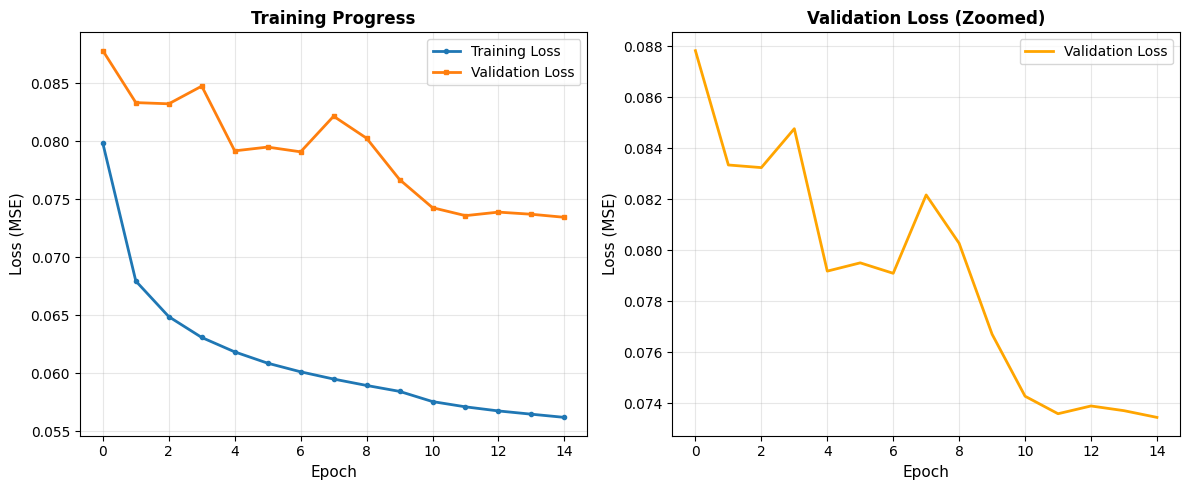

Training curves saved to ../models/training_curves.png


In [14]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_mse, label='Training Loss', linewidth=2, marker='o', markersize=3)
plt.plot(val_losses_mse, label='Validation Loss', linewidth=2, marker='s', markersize=3)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.title('Training Progress', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_losses_mse, label='Validation Loss', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.title('Validation Loss (Zoomed)', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = MODEL_SAVE_DIR / 'training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to {plot_path}")

## SSIM and PSNR Metrics for MSE Model

In [15]:
# Calculate SSIM and PSNR scores for MSE model on test set
all_predictions_mse = torch.cat(predictions, dim=0).numpy()  # (N, 1, H, W)
all_targets_mse = torch.cat(targets_list, dim=0).numpy()      # (N, 1, H, W)

ssim_scores_mse = []
psnr_scores_mse = []

print("\n" + "="*70)
print("COMPUTING QUALITY METRICS FOR MSE MODEL")
print("="*70)

for i in range(len(all_predictions_mse)):
    pred = all_predictions_mse[i, 0]  # (H, W)
    target = all_targets_mse[i, 0]     # (H, W)
    
    # Normalize to [0, 1] range for consistent metric calculation
    pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    target_norm = (target - target.min()) / (target.max() - target.min() + 1e-8)
    
    # Calculate SSIM with fixed data_range=1.0
    ssim_score = ssim(target_norm, pred_norm, data_range=1.0)
    ssim_scores_mse.append(ssim_score)
    
    # Calculate PSNR with fixed data_range=1.0
    psnr_score = psnr(target_norm, pred_norm, data_range=1.0)
    psnr_scores_mse.append(psnr_score)

ssim_scores_mse = np.array(ssim_scores_mse)
psnr_scores_mse = np.array(psnr_scores_mse)

print(f"\n📊 MSE MODEL - IMAGE QUALITY METRICS:")
print(f"\n{'Metric':<20} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
print(f"{'-'*68}")
print(f"{'SSIM':20} {ssim_scores_mse.mean():<12.4f} {ssim_scores_mse.std():<12.4f} {ssim_scores_mse.min():<12.4f} {ssim_scores_mse.max():<12.4f}")
print(f"{'PSNR (dB)':20} {psnr_scores_mse.mean():<12.4f} {psnr_scores_mse.std():<12.4f} {psnr_scores_mse.min():<12.4f} {psnr_scores_mse.max():<12.4f}")


COMPUTING QUALITY METRICS FOR MSE MODEL

📊 MSE MODEL - IMAGE QUALITY METRICS:

Metric               Mean         Std Dev      Min          Max         
--------------------------------------------------------------------
SSIM                 0.7642       0.1261       0.1587       0.9875      
PSNR (dB)            25.4907      4.8217       7.3348       47.5027     


## Save Training Logs

In [19]:
# Save training history
history = {
    'train_losses': train_losses_mse,
    'val_losses': val_losses_mse,
    'test_loss': test_loss,
    'best_val_loss': best_val_loss_mse,
    'epochs_trained': len(train_losses_mse),
    'config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'early_stopping_patience': EARLY_STOPPING_PATIENCE,
        'augmentation': AUGMENT,
        'init_features': 64
    },
    'timestamp': datetime.now().isoformat()
}

log_path = MODEL_SAVE_DIR / 'training_history.json'
with open(log_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"Training history saved to {log_path}")
print(f"\nTraining Summary:")
print(f"   Epochs trained: {len(train_losses_mse)}")
print(f"   Best validation loss: {best_val_loss_mse:.4f}")
print(f"   Final test loss: {test_loss:.4f}")
print(f"   Final train loss: {train_losses_mse[-1]:.4f}")

Training history saved to ../models/training_history.json

Training Summary:
   Epochs trained: 15
   Best validation loss: 0.0735
   Final test loss: 0.0713
   Final train loss: 0.0562


## Prediction Visualization

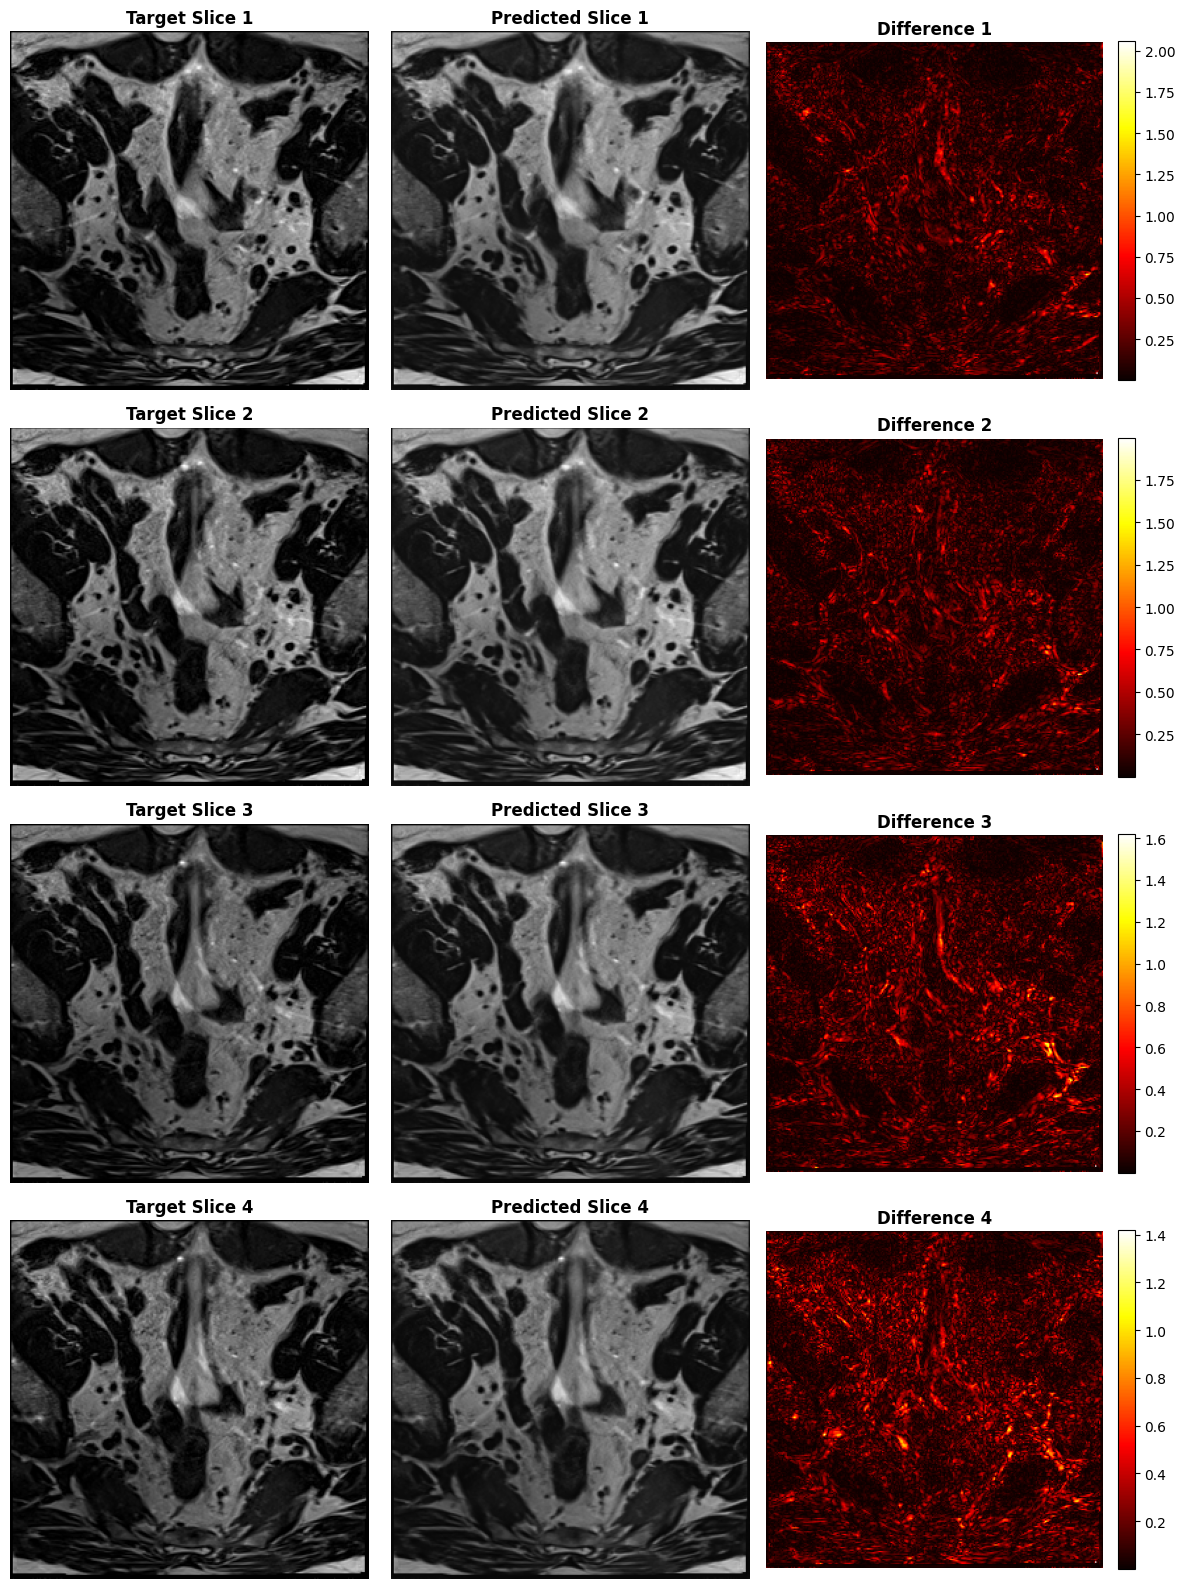

Predictions visualization saved to ../models/predictions_visualization.png


In [20]:
# Concatenate all predictions and targets
all_predictions = torch.cat(predictions, dim=0)  # (N, 1, H, W)
all_targets = torch.cat(targets_list, dim=0)      # (N, 1, H, W)

# Visualize some predictions
n_samples = 4
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

for i in range(n_samples):
    pred = all_predictions[i, 0].numpy()
    target = all_targets[i, 0].numpy()
    diff = np.abs(pred - target)
    
    axes[i, 0].imshow(target, cmap='gray')
    axes[i, 0].set_title(f'Target Slice {i+1}', fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(pred, cmap='gray')
    axes[i, 1].set_title(f'Predicted Slice {i+1}', fontweight='bold')
    axes[i, 1].axis('off')
    
    im = axes[i, 2].imshow(diff, cmap='hot')
    axes[i, 2].set_title(f'Difference {i+1}', fontweight='bold')
    axes[i, 2].axis('off')
    plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
pred_path = MODEL_SAVE_DIR / 'predictions_visualization.png'
plt.savefig(pred_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Predictions visualization saved to {pred_path}")

## Model Save Summary

In [23]:
print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\nModels saved to: {MODEL_SAVE_DIR}")
print(f"\nFiles created:")

for file in sorted(MODEL_SAVE_DIR.glob('*')):
    if('unet_best' in file.name and 'progressive' not in file.name):
        size = file.stat().st_size / (1024*1024)  # MB
        print(f"{file.name:40s} ({size:6.2f} MB)")

print(f"\nKey Results:")
print(f"   Best Validation Loss: {best_val_loss_mse:.4f}")
print(f"   Final Test Loss: {test_loss:.4f}")
print(f"   Total Epochs: {len(train_losses_mse)}")
print(f"   Improvement: {(train_losses_mse[0] - test_loss) / train_losses_mse[0] * 100:.2f}%")
print("\n" + "="*70)


TRAINING COMPLETED SUCCESSFULLY!

Models saved to: ../models

Files created:
unet_best.pt                             (355.41 MB)

Key Results:
   Best Validation Loss: 0.0735
   Final Test Loss: 0.0713
   Total Epochs: 15
   Improvement: 10.73%



# MSE + Perceptual + SSIM Loss

In [10]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer='relu5_1', device='cpu'):
        
        super(PerceptualLoss, self).__init__()
        
        # Load pre-trained VGG16
        vgg = models.vgg16(pretrained=True)
        
        # Layer mapping for different perceptual losses
        layer_name_mapping = {
            'relu1_1': 2,
            'relu2_1': 7,
            'relu3_1': 12,
            'relu4_1': 21,
            'relu5_1': 30
        }
        
        max_layer = layer_name_mapping.get(layer, 30)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:max_layer]).to(device)
        
        # Freeze parameters
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.device = device
        print(f"Perceptual Loss initialized with VGG16 layer: {layer}")
    
    def forward(self, pred, target):
    
        # Repeat grayscale to 3 channels for VGG
        pred_3ch = pred.repeat(1, 3, 1, 1)
        target_3ch = target.repeat(1, 3, 1, 1)
        
        # Normalize using ImageNet statistics
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)
        
        pred_3ch = (pred_3ch - mean) / std
        target_3ch = (target_3ch - mean) / std
        
        # Extract features
        pred_features = self.feature_extractor(pred_3ch)
        target_features = self.feature_extractor(target_3ch)
        
        # L1 loss on features
        loss = F.l1_loss(pred_features, target_features)
        
        del pred_3ch, target_3ch, pred_features, target_features
        
        return loss

In [11]:
class SSIMLoss(nn.Module):
    
    def __init__(self, window_size=11, sigma=1.5):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.sigma = sigma
        self.channel = 1
    
    def create_window(self, window_size, sigma):
        """Create Gaussian window for SSIM"""
        x = torch.arange(window_size).float() - (window_size - 1) / 2.0
        gauss = torch.exp(-x.pow(2.0) / (2 * sigma ** 2))
        return gauss / gauss.sum()
    
    def forward(self, pred, target, reduction='mean'):
        
        # Create Gaussian window
        window = self.create_window(self.window_size, self.sigma)
        window = window.view(-1, 1)  # (window_size, 1) - 2D tensor
        window = torch.mm(window, window.t())  # Outer product
        window = window.view(1, 1, self.window_size, self.window_size)
        window = window.repeat(self.channel, 1, 1, 1).to(pred.device)
        
        # Mean and variance
        mu1 = F.conv2d(pred, window, padding=self.window_size // 2, groups=self.channel)
        mu2 = F.conv2d(target, window, padding=self.window_size // 2, groups=self.channel)
        
        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.conv2d(pred * pred, window, padding=self.window_size // 2, groups=self.channel) - mu1_sq
        sigma2_sq = F.conv2d(target * target, window, padding=self.window_size // 2, groups=self.channel) - mu2_sq
        sigma12 = F.conv2d(pred * target, window, padding=self.window_size // 2, groups=self.channel) - mu1_mu2
        
        # SSIM constants
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        if reduction == 'mean':
            return 1 - ssim_map.mean()
        elif reduction == 'none':
            return 1 - ssim_map
        else:
            return 1 - ssim_map.sum()

In [12]:
class CombinedLoss(nn.Module):
    
    def __init__(self, alpha=1.0, beta=0.01, gamma=0.01, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        self.mse_loss = nn.MSELoss()
        self.perceptual_loss = PerceptualLoss(layer='relu5_1', device=device)
        self.ssim_loss = SSIMLoss()
        
        print(f"Combined Loss initialized:")
        print(f"   α (MSE weight): {alpha}")
        print(f"   β (Perceptual weight): {beta}")
        print(f"   γ (SSIM weight): {gamma}")
        print(f"\n   Note: Reduced perceptual and SSIM weights for training stability")
    
    def forward(self, pred, target):
        
        mse = self.mse_loss(pred, target)
        perceptual = self.perceptual_loss(pred, target)
        ssim = self.ssim_loss(pred, target)
        
        # Normalize SSIM to roughly same scale as MSE (SSIM is 0-1, so scale by factor)
        ssim_scaled = ssim * 0.5  # Reduce SSIM impact
        
        combined = self.alpha * mse + self.beta * perceptual + self.gamma * ssim_scaled
        
        return combined, mse, perceptual, ssim


print("Stabilized Combined Loss defined with reduced perceptual and SSIM weights")

Stabilized Combined Loss defined with reduced perceptual and SSIM weights


## Alternative Loss Configurations (Choose One)

In [13]:
"""
LOSS CONFIGURATION OPTIONS FOR STABILITY

Choose one configuration below based on your priority:

1. CONSERVATIVE (Most Stable - Recommended First):
   - α=1.0, β=0.01, γ=0.01
   - MSE-focused with tiny perceptual/SSIM contributions
   - Best for stable training, gradual improvement

2. BALANCED:
   - α=1.0, β=0.05, γ=0.05
   - Moderate contribution from all components
   - Good balance between stability and enhancement

3. AGGRESSIVE:
   - α=1.0, β=0.1, γ=0.1
   - High weight on perceptual and SSIM
   - Less stable but more perceptual quality focus

4. PERCEPTUAL-FOCUSED:
   - α=0.8, β=0.1, γ=0.0
   - Skip SSIM, focus on MSE + Perceptual
   - Good for visual quality without SSIM instability

Current: CONSERVATIVE (α=1.0, β=0.01, γ=0.01)
"""

# Uncomment the configuration you want to use:

# Option 1: CONSERVATIVE (Current - Most Stable)
loss_config = {'alpha': 1.0, 'beta': 0.01, 'gamma': 0.01, 'name': 'CONSERVATIVE'}

# Option 2: BALANCED
# loss_config = {'alpha': 1.0, 'beta': 0.05, 'gamma': 0.05, 'name': 'BALANCED'}

# Option 3: AGGRESSIVE
# loss_config = {'alpha': 1.0, 'beta': 0.1, 'gamma': 0.1, 'name': 'AGGRESSIVE'}

# Option 4: PERCEPTUAL-FOCUSED (No SSIM)
# loss_config = {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.0, 'name': 'PERCEPTUAL-FOCUSED'}

print(f"✅ Using {loss_config['name']} configuration")
print(f"   α={loss_config['alpha']}, β={loss_config['beta']}, γ={loss_config['gamma']}")

✅ Using CONSERVATIVE configuration
   α=1.0, β=0.01, γ=0.01


## Model and Loss Definition

In [14]:
# Initialize fresh model and optimizer for combined loss training
model_combined = UNet(in_channels=2, out_channels=1, init_features=64).to(DEVICE)
optimizer_combined = optim.Adam(model_combined.parameters(), lr=LEARNING_RATE)

# Initialize combined loss criterion with configured weights
criterion_combined = CombinedLoss(
    alpha=loss_config['alpha'], 
    beta=loss_config['beta'], 
    gamma=loss_config['gamma'], 
    device=DEVICE
)

print(f"Combined Loss Model initialized on {DEVICE}")
print(f"Total parameters: {sum(p.numel() for p in model_combined.parameters()):,}")
print(f"\nConfiguration:")
print(f"   Loss: {loss_config['name']}")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Epochs: {EPOCHS}")
print(f"   Early stopping patience: {EARLY_STOPPING_PATIENCE}")

/blue/cruzcastrol/dthiyagarajan/.conda/envs/dlmia-2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/blue/cruzcastrol/dthiyagarajan/.conda/envs/dlmia-2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Perceptual Loss initialized with VGG16 layer: relu5_1
Combined Loss initialized:
   α (MSE weight): 1.0
   β (Perceptual weight): 0.01
   γ (SSIM weight): 0.01

   Note: Reduced perceptual and SSIM weights for training stability
Combined Loss Model initialized on cuda
Total parameters: 31,042,945

Configuration:
   Loss: CONSERVATIVE
   Optimizer: Adam (lr=0.0001)
   Epochs: 20
   Early stopping patience: 5


## TRAINING SETUP 2: COMBINED LOSS

In [15]:
# ========== Checkpoint Setup for Combined Loss Training ==========
CHECKPOINT_DIR_COMBINED = MODEL_SAVE_DIR
CHECKPOINT_DIR_COMBINED.mkdir(parents=True, exist_ok=True)

print("🔍 Checking for existing Combined Loss checkpoints...")
latest_combined_ckpt = get_latest_checkpoint(CHECKPOINT_DIR_COMBINED, prefix='unet_combined_checkpoint')

if latest_combined_ckpt is not None:
    latest_ckpt_path, latest_epoch = latest_combined_ckpt
    print(f"📂 Found checkpoint: {latest_ckpt_path.name}")
    
    # Load checkpoint
    start_epoch_combined, train_losses_combined, val_losses_combined, best_val_loss_combined, loss_components_combined = load_checkpoint(
        model_combined, optimizer_combined, latest_ckpt_path, DEVICE
    )
    
    # Restore loss components
    train_mse_combined = loss_components_combined.get('train_mse', [])
    train_perc_combined = loss_components_combined.get('train_perc', [])
    train_ssim_combined = loss_components_combined.get('train_ssim', [])
    val_mse_combined = loss_components_combined.get('val_mse', [])
    val_perc_combined = loss_components_combined.get('val_perc', [])
    val_ssim_combined = loss_components_combined.get('val_ssim', [])
    
    print(f"✅ Loaded checkpoint from epoch {latest_epoch}")
    print(f"   Resuming training from epoch {start_epoch_combined}")
    print(f"   Best validation loss so far: {best_val_loss_combined:.4f}")
    print(f"   Previous epochs: {len(train_losses_combined)}\n")
else:
    print("📭 No Combined Loss checkpoint found - starting fresh training\n")
    start_epoch_combined = 1
    train_losses_combined = []
    val_losses_combined = []
    train_mse_combined = []
    train_perc_combined = []
    train_ssim_combined = []
    val_mse_combined = []
    val_perc_combined = []
    val_ssim_combined = []
    best_val_loss_combined = float('inf')
    loss_components_combined = {}

print("✅ Combined Loss Training Setup Complete")

🔍 Checking for existing Combined Loss checkpoints...
📂 Found checkpoint: unet_combined_checkpoint_19.pt
✅ Loaded checkpoint from epoch 19
   Resuming training from epoch 20
   Best validation loss so far: 0.0771
   Previous epochs: 19

✅ Combined Loss Training Setup Complete


## Training loop for Combined Loss

In [16]:
def train_epoch_combined(model, train_loader, optimizer, criterion, device):
    """Train for one epoch with combined loss"""
    model.train()
    total_loss = 0.0
    total_mse = 0.0
    total_perc = 0.0
    total_ssim = 0.0
    
    pbar = tqdm(train_loader, desc="Training (Combined)", leave=False)
    for (pre, post), target in pbar:
        # Stack prior and posterior as input (2 channels)
        inputs = torch.cat([pre, post], dim=1).to(device)
        targets = target.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss, mse, perceptual, ssim = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_mse += mse.item()
        total_perc += perceptual.item()
        total_ssim += ssim.item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'mse': f'{mse.item():.4f}',
            'perc': f'{perceptual.item():.4f}',
            'ssim': f'{ssim.item():.4f}'
        })
        
        # Clear GPU cache to prevent OOM
        del inputs, outputs, targets, loss, mse, perceptual, ssim
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    return (total_loss / len(train_loader), 
            total_mse / len(train_loader),
            total_perc / len(train_loader),
            total_ssim / len(train_loader))

In [17]:
def validate_combined(model, val_loader, criterion, device):
    """Validate model with combined loss"""
    model.eval()
    total_loss = 0.0
    total_mse = 0.0
    total_perc = 0.0
    total_ssim = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating (Combined)", leave=False)
        for (pre, post), target in pbar:
            # Stack prior and posterior as input (2 channels)
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss, mse, perceptual, ssim = criterion(outputs, targets)
            
            total_loss += loss.item()
            total_mse += mse.item()
            total_perc += perceptual.item()
            total_ssim += ssim.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'mse': f'{mse.item():.4f}',
                'perc': f'{perceptual.item():.4f}',
                'ssim': f'{ssim.item():.4f}'
            })
            
            # Clear GPU cache to prevent OOM
            del inputs, outputs, targets, loss, mse, perceptual, ssim
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    return (total_loss / len(val_loader),
            total_mse / len(val_loader),
            total_perc / len(val_loader),
            total_ssim / len(val_loader))

## Epoch 1-10

In [ ]:
# Initialize training variables from checkpoint if resuming
if start_epoch_combined > 1:
    print(f"📊 Resuming Combined Loss Training from epoch {start_epoch_combined}")
    print(f"   Previous epochs: {len(train_losses_combined)}")
    print(f"   Best val loss: {best_val_loss_combined:.4f}\n")
else:
    print(f"🆕 Starting fresh Combined Loss training\n")

patience_counter_combined = 0

print(f"Starting Combined Loss training...\n")
print("=" * 90)

for epoch in range(start_epoch_combined, EPOCHS + 1):
    train_loss, train_mse, train_perc, train_ssim = train_epoch_combined(
        model_combined, train_loader, optimizer_combined, criterion_combined, DEVICE
    )
    val_loss, val_mse, val_perc, val_ssim = validate_combined(
        model_combined, val_loader, criterion_combined, DEVICE
    )
    
    train_losses_combined.append(train_loss)
    val_losses_combined.append(val_loss)
    train_mse_combined.append(train_mse)
    train_perc_combined.append(train_perc)
    train_ssim_combined.append(train_ssim)
    val_mse_combined.append(val_mse)
    val_perc_combined.append(val_perc)
    val_ssim_combined.append(val_ssim)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Val Loss: {val_loss:.4f} (MSE: {val_mse:.4f} | Perc: {val_perc:.4f} | SSIM: {val_ssim:.4f})", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_combined:
            best_val_loss_combined = val_loss
            patience_counter_combined = 0
            
            # Save best combined model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model_combined.state_dict(),
                'optimizer_state_dict': optimizer_combined.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_combined,
                'val_losses': val_losses_combined,
                'loss_components': {
                    'train_mse': train_mse_combined,
                    'train_perc': train_perc_combined,
                    'train_ssim': train_ssim_combined,
                    'val_mse': val_mse_combined,
                    'val_perc': val_perc_combined,
                    'val_ssim': val_ssim_combined
                }
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_combined_best.pt')
            print("(Best)")
        else:
            patience_counter_combined += 1
            print(f" (patience: {patience_counter_combined}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_combined >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        loss_components_to_save = {
            'train_mse': train_mse_combined,
            'train_perc': train_perc_combined,
            'train_ssim': train_ssim_combined,
            'val_mse': val_mse_combined,
            'val_perc': val_perc_combined,
            'val_ssim': val_ssim_combined
        }
        checkpoint_path = CHECKPOINT_DIR_COMBINED / f'unet_combined_checkpoint_{epoch}.pt'
        save_checkpoint(model_combined, optimizer_combined, epoch, train_losses_combined, 
                       val_losses_combined, loss_components_to_save, best_val_loss_combined, checkpoint_path)

print("=" * 90)
print(f"Combined Loss Training completed!")
print(f"Best validation loss: {best_val_loss_combined:.4f}")
print(f"Total epochs trained: {len(train_losses_combined)}")


Starting Combined Loss training...



Epoch   1/10 | Val Loss: 0.0921 (MSE: 0.0876 | Perc: 0.2411 | SSIM: 0.4173)(Best)


Epoch   2/10 | Val Loss: 0.0870 (MSE: 0.0827 | Perc: 0.2334 | SSIM: 0.3979)(Best)


Epoch   3/10 | Val Loss: 0.0847 (MSE: 0.0804 | Perc: 0.2356 | SSIM: 0.3950)(Best)


Epoch   4/10 | Val Loss: 0.0837 (MSE: 0.0794 | Perc: 0.2346 | SSIM: 0.3930)(Best)


Training (Combined):  17%|█▋        | 3150/18269 [11:05<1:02:56,  4.00it/s, loss=0.0622, mse=0.0582, perc=0.2155, ssim=0.3763]

## Epoch 10-14

In [ ]:
# Initialize training variables from checkpoint if resuming
if start_epoch_combined > 1:
    print(f"📊 Resuming Combined Loss Training from epoch {start_epoch_combined}")
    print(f"   Previous epochs: {len(train_losses_combined)}")
    print(f"   Best val loss: {best_val_loss_combined:.4f}\n")
else:
    print(f"🆕 Starting fresh Combined Loss training\n")

patience_counter_combined = 0

print(f"Starting Combined Loss training...\n")
print("=" * 90)

for epoch in range(start_epoch_combined, EPOCHS + 1):
    train_loss, train_mse, train_perc, train_ssim = train_epoch_combined(
        model_combined, train_loader, optimizer_combined, criterion_combined, DEVICE
    )
    val_loss, val_mse, val_perc, val_ssim = validate_combined(
        model_combined, val_loader, criterion_combined, DEVICE
    )
    
    train_losses_combined.append(train_loss)
    val_losses_combined.append(val_loss)
    train_mse_combined.append(train_mse)
    train_perc_combined.append(train_perc)
    train_ssim_combined.append(train_ssim)
    val_mse_combined.append(val_mse)
    val_perc_combined.append(val_perc)
    val_ssim_combined.append(val_ssim)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Val Loss: {val_loss:.4f} (MSE: {val_mse:.4f} | Perc: {val_perc:.4f} | SSIM: {val_ssim:.4f})", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_combined:
            best_val_loss_combined = val_loss
            patience_counter_combined = 0
            
            # Save best combined model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model_combined.state_dict(),
                'optimizer_state_dict': optimizer_combined.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_combined,
                'val_losses': val_losses_combined,
                'loss_components': {
                    'train_mse': train_mse_combined,
                    'train_perc': train_perc_combined,
                    'train_ssim': train_ssim_combined,
                    'val_mse': val_mse_combined,
                    'val_perc': val_perc_combined,
                    'val_ssim': val_ssim_combined
                }
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_combined_best.pt')
            print("(Best)")
        else:
            patience_counter_combined += 1
            print(f" (patience: {patience_counter_combined}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_combined >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        loss_components_to_save = {
            'train_mse': train_mse_combined,
            'train_perc': train_perc_combined,
            'train_ssim': train_ssim_combined,
            'val_mse': val_mse_combined,
            'val_perc': val_perc_combined,
            'val_ssim': val_ssim_combined
        }
        checkpoint_path = CHECKPOINT_DIR_COMBINED / f'unet_combined_checkpoint_{epoch}.pt'
        save_checkpoint(model_combined, optimizer_combined, epoch, train_losses_combined, 
                       val_losses_combined, loss_components_to_save, best_val_loss_combined, checkpoint_path)

print("=" * 90)
print(f"Combined Loss Training completed!")
print(f"Best validation loss: {best_val_loss_combined:.4f}")
print(f"Total epochs trained: {len(train_losses_combined)}")

📊 Resuming Combined Loss Training from epoch 10
   Previous epochs: 9
   Best val loss: 0.0799

Starting Combined Loss training...



Epoch  10/20 | Val Loss: 0.0794 (MSE: 0.0751 | Perc: 0.2353 | SSIM: 0.3847)(Best)


Epoch  11/20 | Val Loss: 0.0787 (MSE: 0.0745 | Perc: 0.2316 | SSIM: 0.3798)(Best)


Epoch  12/20 | Val Loss: 0.0789 (MSE: 0.0746 | Perc: 0.2331 | SSIM: 0.3804) (patience: 1/5)


Epoch  13/20 | Val Loss: 0.0779 (MSE: 0.0737 | Perc: 0.2294 | SSIM: 0.3752)(Best)


Validating (Combined):  32%|███▏      | 1017/3221 [05:36<12:08,  3.02it/s, loss=0.1177, mse=0.1122, perc=0.2588, ssim=0.5737]    IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch  14/20 | Val Loss: 0.0797 (MSE: 0.0753 | Perc: 0.2391 | SSIM: 0.3913) (patience: 1/5)


Training (Combined):  59%|█████▊    | 10694/18269 [1:04:28<47:07,  2.68it/s, loss=0.0628, mse=0.0587, perc=0.2213, ssim=0.3810]  

## Epoch 15 and above

In [ ]:
# Initialize training variables from checkpoint if resuming
if start_epoch_combined > 1:
    print(f"📊 Resuming Combined Loss Training from epoch {start_epoch_combined}")
    print(f"   Previous epochs: {len(train_losses_combined)}")
    print(f"   Best val loss: {best_val_loss_combined:.4f}\n")
else:
    print(f"🆕 Starting fresh Combined Loss training\n")

patience_counter_combined = 0

print(f"Starting Combined Loss training...\n")
print("=" * 90)

for epoch in range(start_epoch_combined, EPOCHS + 1):
    train_loss, train_mse, train_perc, train_ssim = train_epoch_combined(
        model_combined, train_loader, optimizer_combined, criterion_combined, DEVICE
    )
    val_loss, val_mse, val_perc, val_ssim = validate_combined(
        model_combined, val_loader, criterion_combined, DEVICE
    )
    
    train_losses_combined.append(train_loss)
    val_losses_combined.append(val_loss)
    train_mse_combined.append(train_mse)
    train_perc_combined.append(train_perc)
    train_ssim_combined.append(train_ssim)
    val_mse_combined.append(val_mse)
    val_perc_combined.append(val_perc)
    val_ssim_combined.append(val_ssim)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Val Loss: {val_loss:.4f} (MSE: {val_mse:.4f} | Perc: {val_perc:.4f} | SSIM: {val_ssim:.4f})", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_combined:
            best_val_loss_combined = val_loss
            patience_counter_combined = 0
            
            # Save best combined model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model_combined.state_dict(),
                'optimizer_state_dict': optimizer_combined.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_combined,
                'val_losses': val_losses_combined,
                'loss_components': {
                    'train_mse': train_mse_combined,
                    'train_perc': train_perc_combined,
                    'train_ssim': train_ssim_combined,
                    'val_mse': val_mse_combined,
                    'val_perc': val_perc_combined,
                    'val_ssim': val_ssim_combined
                }
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_combined_best.pt')
            print("(Best)")
        else:
            patience_counter_combined += 1
            print(f" (patience: {patience_counter_combined}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_combined >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        loss_components_to_save = {
            'train_mse': train_mse_combined,
            'train_perc': train_perc_combined,
            'train_ssim': train_ssim_combined,
            'val_mse': val_mse_combined,
            'val_perc': val_perc_combined,
            'val_ssim': val_ssim_combined
        }
        checkpoint_path = CHECKPOINT_DIR_COMBINED / f'unet_combined_checkpoint_{epoch}.pt'
        save_checkpoint(model_combined, optimizer_combined, epoch, train_losses_combined, 
                       val_losses_combined, loss_components_to_save, best_val_loss_combined, checkpoint_path)

print("=" * 90)
print(f"Combined Loss Training completed!")
print(f"Best validation loss: {best_val_loss_combined:.4f}")
print(f"Total epochs trained: {len(train_losses_combined)}")

📊 Resuming Combined Loss Training from epoch 15
   Previous epochs: 14
   Best val loss: 0.0779

Starting Combined Loss training...



Epoch  15/20 | Val Loss: 0.0787 (MSE: 0.0744 | Perc: 0.2325 | SSIM: 0.3806) (patience: 1/5)


Epoch  16/20 | Val Loss: 0.0776 (MSE: 0.0734 | Perc: 0.2316 | SSIM: 0.3773)(Best)


Epoch  17/20 | Val Loss: 0.0784 (MSE: 0.0741 | Perc: 0.2339 | SSIM: 0.3816) (patience: 1/5)


Epoch  18/20 | Val Loss: 0.0778 (MSE: 0.0736 | Perc: 0.2293 | SSIM: 0.3766) (patience: 2/5)


Epoch  19/20 | Val Loss: 0.0771 (MSE: 0.0730 | Perc: 0.2293 | SSIM: 0.3745)(Best)


Training (Combined):  62%|██████▏   | 11306/18269 [1:08:09<43:40,  2.66it/s, loss=0.0983, mse=0.0935, perc=0.2536, ssim=0.4499]  

## Epoch 20

In [ ]:
# Initialize training variables from checkpoint if resuming
if start_epoch_combined > 1:
    print(f"📊 Resuming Combined Loss Training from epoch {start_epoch_combined}")
    print(f"   Previous epochs: {len(train_losses_combined)}")
    print(f"   Best val loss: {best_val_loss_combined:.4f}\n")
else:
    print(f"🆕 Starting fresh Combined Loss training\n")

patience_counter_combined = 0

print(f"Starting Combined Loss training...\n")
print("=" * 90)

for epoch in range(start_epoch_combined, EPOCHS + 1):
    train_loss, train_mse, train_perc, train_ssim = train_epoch_combined(
        model_combined, train_loader, optimizer_combined, criterion_combined, DEVICE
    )
    val_loss, val_mse, val_perc, val_ssim = validate_combined(
        model_combined, val_loader, criterion_combined, DEVICE
    )
    
    train_losses_combined.append(train_loss)
    val_losses_combined.append(val_loss)
    train_mse_combined.append(train_mse)
    train_perc_combined.append(train_perc)
    train_ssim_combined.append(train_ssim)
    val_mse_combined.append(val_mse)
    val_perc_combined.append(val_perc)
    val_ssim_combined.append(val_ssim)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Val Loss: {val_loss:.4f} (MSE: {val_mse:.4f} | Perc: {val_perc:.4f} | SSIM: {val_ssim:.4f})", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_combined:
            best_val_loss_combined = val_loss
            patience_counter_combined = 0
            
            # Save best combined model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model_combined.state_dict(),
                'optimizer_state_dict': optimizer_combined.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_combined,
                'val_losses': val_losses_combined,
                'loss_components': {
                    'train_mse': train_mse_combined,
                    'train_perc': train_perc_combined,
                    'train_ssim': train_ssim_combined,
                    'val_mse': val_mse_combined,
                    'val_perc': val_perc_combined,
                    'val_ssim': val_ssim_combined
                }
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'unet_combined_best.pt')
            print("(Best)")
        else:
            patience_counter_combined += 1
            print(f" (patience: {patience_counter_combined}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_combined >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        loss_components_to_save = {
            'train_mse': train_mse_combined,
            'train_perc': train_perc_combined,
            'train_ssim': train_ssim_combined,
            'val_mse': val_mse_combined,
            'val_perc': val_perc_combined,
            'val_ssim': val_ssim_combined
        }
        checkpoint_path = CHECKPOINT_DIR_COMBINED / f'unet_combined_checkpoint_{epoch}.pt'
        save_checkpoint(model_combined, optimizer_combined, epoch, train_losses_combined, 
                       val_losses_combined, loss_components_to_save, best_val_loss_combined, checkpoint_path)

print("=" * 90)
print(f"Combined Loss Training completed!")
print(f"Best validation loss: {best_val_loss_combined:.4f}")
print(f"Total epochs trained: {len(train_losses_combined)}")

📊 Resuming Combined Loss Training from epoch 20
   Previous epochs: 19
   Best val loss: 0.0771

Starting Combined Loss training...



Validating (Combined):  24%|██▎       | 758/3221 [03:56<11:35,  3.54it/s, loss=0.1443, mse=0.1385, perc=0.3214, ssim=0.5231]     

## Model Evaluation on Test Set

In [ ]:
def evaluate_combined(model, test_loader, criterion, device):
    """Evaluate combined loss model on test set"""
    model.eval()
    total_loss = 0.0
    total_mse = 0.0
    total_perc = 0.0
    total_ssim = 0.0
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing (Combined)", leave=False)
        for (pre, post), target in pbar:
            # Stack prior and posterior as input (2 channels)
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss, mse, perceptual, ssim = criterion(outputs, targets)
            
            total_loss += loss.item()
            total_mse += mse.item()
            total_perc += perceptual.item()
            total_ssim += ssim.item()
            
            predictions.append(outputs.cpu())
            targets_list.append(targets.cpu())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(test_loader)
    avg_mse = total_mse / len(test_loader)
    avg_perc = total_perc / len(test_loader)
    avg_ssim = total_ssim / len(test_loader)
    
    # Final cleanup after evaluation
    if device == 'cuda':
        torch.cuda.empty_cache()
        gc.collect()
    
    return avg_loss, avg_mse, avg_perc, avg_ssim, predictions, targets_list


# Load best combined model
best_combined_path = MODEL_SAVE_DIR / 'unet_combined_best.pt'
if best_combined_path.exists():
    checkpoint = torch.load(best_combined_path, map_location=DEVICE)
    model_combined.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best combined model loaded from epoch {checkpoint['epoch']}")
else:
    print("Best combined model not found, using current model")

# Evaluate on test set
print("\nEvaluating Combined Loss Model on test set...\n")
test_loss_comb, test_mse_comb, test_perc_comb, test_ssim_comb, predictions_comb, targets_list_comb = evaluate_combined(
    model_combined, test_loader, criterion_combined, DEVICE
)

print(f"\nCombined Loss Model Test Results:")
print(f"   Total Loss: {test_loss_comb:.4f}")
print(f"   MSE Loss: {test_mse_comb:.4f}")
print(f"   Perceptual Loss: {test_perc_comb:.4f}")
print(f"   SSIM Loss: {test_ssim_comb:.4f}")

In [ ]:
# Calculate SSIM and PSNR scores for Combined Loss model on test set
all_predictions_comb = torch.cat(predictions_comb, dim=0).numpy()  # (N, 1, H, W)
all_targets_comb = torch.cat(targets_list_comb, dim=0).numpy()      # (N, 1, H, W)

ssim_scores = []
psnr_scores = []

print("\n" + "="*70)
print("COMPUTING QUALITY METRICS FOR COMBINED LOSS MODEL")
print("="*70)

for i in range(len(all_predictions_comb)):
    pred = all_predictions_comb[i, 0]  # (H, W)
    target = all_targets_comb[i, 0]     # (H, W)
    
    # Calculate SSIM (structural similarity)
    # Normalize to [0, 1] range for consistent metric calculation
    pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    target_norm = (target - target.min()) / (target.max() - target.min() + 1e-8)
    
    # Calculate SSIM with fixed data_range=1.0
    ssim_score = ssim(target_norm, pred_norm, data_range=1.0)
    ssim_scores.append(ssim_score)
    
    # Calculate PSNR with fixed data_range=1.0
    psnr_score = psnr(target_norm, pred_norm, data_range=1.0)
    psnr_scores.append(psnr_score)

ssim_scores = np.array(ssim_scores)
psnr_scores = np.array(psnr_scores)

print(f"\n📊 COMBINED LOSS MODEL - IMAGE QUALITY METRICS:")
print(f"\n{'Metric':<20} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
print(f"{'-'*68}")
print(f"{'SSIM':20} {ssim_scores.mean():<12.4f} {ssim_scores.std():<12.4f} {ssim_scores.min():<12.4f} {ssim_scores.max():<12.4f}")
print(f"{'PSNR (dB)':20} {psnr_scores.mean():<12.4f} {psnr_scores.std():<12.4f} {psnr_scores.min():<12.4f} {psnr_scores.max():<12.4f}")

print(f"\n📈 Per-Sample SSIM Scores (first 10 samples):")
for i in range(min(10, len(ssim_scores))):
    print(f"   Sample {i+1:3d}: SSIM = {ssim_scores[i]:.4f}, PSNR = {psnr_scores[i]:.2f} dB")

if len(ssim_scores) > 10:
    print(f"   ... and {len(ssim_scores)-10} more samples")

print("\n" + "="*70)

## Prediction Visualization

In [ ]:
# Note: Combined Loss Training Setup is configured in the checkpoint setup section above
# The training loop uses start_epoch_combined, train_losses_combined, etc. from checkpoint setup
print("✅ Combined Loss training setup complete - ready to run training loop in cell above")

## Training Loss Curves and Summary

In [ ]:
# Plot combined loss training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss comparison
axes[0, 0].plot(train_losses_combined, label='Training Loss', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(val_losses_combined, label='Validation Loss', linewidth=2, marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch', fontsize=10)
axes[0, 0].set_ylabel('Combined Loss', fontsize=10)
axes[0, 0].set_title('Combined Loss: Total Loss', fontsize=11, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# MSE component
axes[0, 1].plot(train_mse_combined, label='Train MSE', linewidth=2, marker='o', markersize=3, color='blue')
axes[0, 1].plot(val_mse_combined, label='Val MSE', linewidth=2, marker='s', markersize=3, color='cyan')
axes[0, 1].set_xlabel('Epoch', fontsize=10)
axes[0, 1].set_ylabel('MSE Loss', fontsize=10)
axes[0, 1].set_title('Loss Component: MSE', fontsize=11, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Perceptual component
axes[1, 0].plot(train_perc_combined, label='Train Perceptual', linewidth=2, marker='o', markersize=3, color='green')
axes[1, 0].plot(val_perc_combined, label='Val Perceptual', linewidth=2, marker='s', markersize=3, color='lightgreen')
axes[1, 0].set_xlabel('Epoch', fontsize=10)
axes[1, 0].set_ylabel('Perceptual Loss', fontsize=10)
axes[1, 0].set_title('Loss Component: Perceptual', fontsize=11, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# SSIM component
axes[1, 1].plot(train_ssim_combined, label='Train SSIM', linewidth=2, marker='o', markersize=3, color='red')
axes[1, 1].plot(val_ssim_combined, label='Val SSIM', linewidth=2, marker='s', markersize=3, color='lightcoral')
axes[1, 1].set_xlabel('Epoch', fontsize=10)
axes[1, 1].set_ylabel('SSIM Loss', fontsize=10)
axes[1, 1].set_title('Loss Component: SSIM', fontsize=11, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
combined_plot_path = MODEL_SAVE_DIR / 'training_curves_combined.png'
plt.savefig(combined_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Combined loss training curves saved to {combined_plot_path}")

In [ ]:
print("\n" + "="*70)
print("COMBINED LOSS TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"\nCombined Loss Models saved to: {MODEL_SAVE_DIR}")
print(f"\nNew files created:")
print(f"{'unet_combined_best.pt':40s} (Combined loss best checkpoint)")
print(f"{'training_curves_combined.png':40s} (Combined loss curves)")

print(f"\nCombined Loss Model Results:")
print(f"   Loss Function: MSE (α=1.0) + Perceptual (β=0.1) + SSIM (γ=0.1)")
print(f"   Best Validation Loss: {best_val_loss_combined:.4f}")
print(f"   Final Test Loss: {test_loss_comb:.4f}")
print(f"   Final Test MSE: {test_mse_comb:.4f}")
print(f"   Final Test Perceptual: {test_perc_comb:.4f}")
print(f"   Final Test SSIM: {test_ssim_comb:.4f}")
print(f"   Total Epochs: {len(train_losses_combined)}")

print(f"\nComparison: MSE vs Combined Loss")
print(f"   {'Model':20} {'Val Loss':12} {'Test Loss':12} {'Epochs':8}")
print(f"   {'-'*60}")
print(f"   {'MSE Only':20} {best_val_loss:10.4f}   {test_loss:10.4f}   {len(train_losses):6}")
print(f"   {'Combined':20} {best_val_loss_combined:10.4f}   {test_loss_comb:10.4f}   {len(train_losses_combined):6}")

print("\n" + "="*70)